In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from skimage.transform import resize
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tkinter as tk
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk


In [2]:
def iou_loss(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [3]:
# Cargar el modelo
model = keras.models.load_model('fracture_model_2.h5', custom_objects={'iou_bce_loss': iou_bce_loss, 'mean_iou': mean_iou})

In [4]:
# Función para cargar la imagen
def load_image(filepath):
    img = Image.open(filepath).convert('L')  # Convertir a escala de grises
    img = np.array(img)
    img = resize(img, (256, 256), mode='reflect', anti_aliasing=True)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

# Función para predecir la imagen
def predict_image(filepath):
    img = load_image(filepath)
    pred = model.predict(img)[0]
    return img[0], pred

# Función para visualizar la predicción
def visualize_prediction(img, pred, canvas, text_var):
    
    plt.close('all') 
    f, axarr = plt.subplots(1, 1, figsize=(6, 6))
    axarr.imshow(img[:, :, 0], cmap='gray')
    axarr.set_title('Original Image')
    comp = pred[:, :, 0] > 0.5
    comp = measure.label(comp)
    for region in measure.regionprops(comp):
        y, x, y2, x2 = region.bbox
        height = y2 - y
        width = x2 - x
        axarr.add_patch(patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none'))

    canvas.figure = f  
    canvas.draw_idle()  
    canvas.get_tk_widget().update_idletasks()  
    threats_detected = [f"Anomaly at (x: {x}, y: {y})" for region in measure.regionprops(comp)]
    text_var.set("\n".join(threats_detected) if threats_detected else "No anomalies detected")

def open_file():  
    filepath = filedialog.askopenfilename(filetypes=[("Image files", "*.png *.jpg *.jpeg")])  
    if filepath:
        img, pred = predict_image(filepath)
        visualize_prediction(img, pred, canvas, text_var)
        
        
def load_background_image(frame, image_path):
    image = Image.open(image_path)
    background_image = ImageTk.PhotoImage(image)
    background_label = tk.Label(frame, image=background_image)
    background_label.image = background_image  # Necesario para evitar que la imagen sea recolectada por el garbage collector
    background_label.place(relwidth=1, relheight=1)  # Ocupa todo el espacio del frame

1/1 [==============================] - 0s 36ms/step


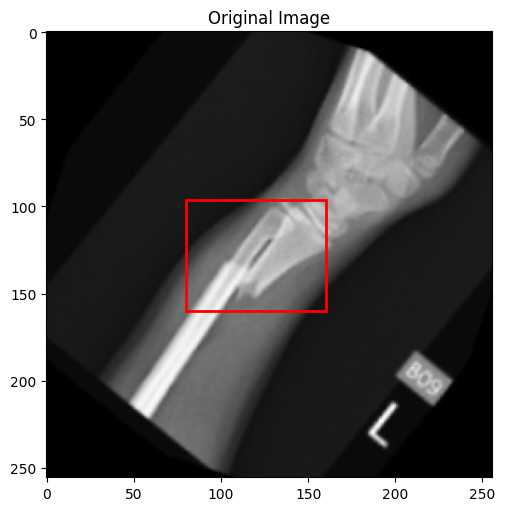

In [5]:
# Crear la ventana de la interfaz gráfica
root = tk.Tk()
root.title("Medical Image Anomaly Detection")
root.geometry('1000x700')
root.resizable(False, False) 

# Estilo del botón
button_style = {
    'font': ('Helvetica', 14),
    'bg': '#508C9B',
    'fg': '#EEEEEE',
    'relief': 'raised',
    'bd': 2,
    'width': 20,
    'height': 2
}



button_frame = tk.Frame(root, bg='#134B70') 
button_frame.pack(pady=20, fill='x') 
btn = tk.Button(button_frame, text="Load and Predict Image", command=open_file, **button_style)
btn.pack(pady=10)  
root.configure(bg='#134B70')  

frame = tk.Frame(root, bg='#508C9B')
frame.pack(fill='both', expand=True)


image_frame = tk.Frame(frame, bg='#508C9B')
image_frame.pack(side='left', fill='both', expand=True)

# Cargar la imagen de fondo para el frame de la imagen
#load_background_image(image_frame, 'w1.jpg')

f = plt.Figure(figsize=(6,6))
ax = f.add_subplot(111)
ax.text(0.5, 0.5, 'Por favor seleccione una imagen', fontsize=12, ha='center')
ax.set_xticks([])
ax.set_yticks([])
canvas = FigureCanvasTkAgg(f, master=image_frame)
canvas.get_tk_widget().pack(expand=True)
canvas.draw_idle()


text_frame = tk.Frame(frame, bg='#f0f0f0')
text_frame.pack(side='right', fill='both', expand=True)

text_var = tk.StringVar()
text_label = tk.Label(text_frame, textvariable=text_var, font=('Helvetica', 12), bg='#f0f0f0', fg='red')
text_label.pack(padx=15, pady=15)

root.mainloop()